**This jupyter notebook demonstrates how to:**

1. Create a multivariate dataset using different data sets


**Mount google drive to access files**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Important defines:
#total number of lift stations
NUMBER_OF_LIFT_STATIONS = 30 

#number of pumps per lift stations
PUMPS_PER_LIFT_STATION  = [2,2,3,3,3,1,2,3,2,2,3,3,2,2,2,
                           2,3,2,2,2,2,2,2,2,2,2,2,2,2,2]

#google drive folder where datasets are stored
DATASETS_DIR = r'/content/gdrive/My Drive/datasets/'                         


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

**Load lift stations register**

This data frame contains characteristics and specifications about sewage lift stations

Some columns (listed above) contains float values with comma instead of dot. 

In [0]:
lift_station_register = pd.read_csv(DATASETS_DIR + r'sewage_pumping_stations_base.csv')

#list of columns to transform into float, changing comma for dot
columns_to_change_to_float = ['utmx', 'utmy', 'nivel_max','vazao_recalque', 
                              'altura_manometrica','extensao_recalque',
                              'potencia_instalada']

for column in columns_to_change_to_float:
  try:
    lift_station_register[column] = lift_station_register[column].str.replace(',', '.').astype(float)
  except:
    print(f'Erro changing type of column: {column}')
    continue


In [5]:
lift_station_register.columns

Index(['index', 'name', 'utmx', 'utmy', 'tipo_bombas', 'quantidade_bombas',
       'vazao_recalque', 'altura_manometrica', 'diametro_recalque',
       'material_recalque', 'extensao_recalque', 'retencao_residuos',
       'sistema_icamento', 'urbanizacao', 'potencia_instalada',
       'combate_a_odores', 'sistema_partida_bombas', 'tipo_sensor_nivel',
       'nivel_max', 'corrente1_max', 'corrente2_max', 'corrente3_max',
       'bomba1', 'bomba2', 'bomba3'],
      dtype='object')

**Weather stations data**

Files where downloaded from http://www.inmet.gov.br/portal/index.php?r=bdmep/bdmep

Weather data are related to Sewage Lift Stations events because because part of the rainwater is improperly connected to the sewer network.

This dataset is composed by data from 9 weather stations wich are located in Belo Horizonte region. They are near sewage lift stations analysed at this master degree work.

Each weather station file contains daily precipitation between January 1, 2010 and December 31, 2018.


In [0]:
#load weather stations register containing ids from all weather stations
weather_stations = pd.read_csv(DATASETS_DIR + r'cadastro_estacoes.csv')

#load 9 weather stations datasets
weather_stations_data_list = []
for i,row in weather_stations.iterrows():
    #load the dataset from each weather station 
    #files names uses the id from each weather station
    weather_station_data = pd.read_csv(DATASETS_DIR + r'estacao_{0}.csv'.format(row['id']),delimiter=';')
    #set the datetime index
    weather_station_data['datahora'] = pd.to_datetime(weather_station_data['Data'],format='%d/%m/%Y')
    weather_station_data.index = pd.to_datetime(weather_station_data['datahora'])
    #change the precipitation column name preparing for concatenation
    new_column_name = f"WeatherStation_{row['id']}"
    weather_station_data = weather_station_data.rename(columns = {'Precipitacao':new_column_name})
    #append each weather station dataset to a list for letter concatenation
    weather_stations_data_list.append(weather_station_data[['datahora',new_column_name]])

#contatenate weather station datasets    
weather_stations_datas = pd.concat(weather_stations_data_list, axis=1)
weather_stations_datas = weather_stations_datas.drop(columns=['datahora',])
#fill values na with 0
weather_stations_datas = weather_stations_datas.fillna(0)

**Intervals with operation interruption from some lift stations**




In [0]:
#some sewage lift station were deactivated after a specific date 
#the dict below helps to get correct operation interval
lifting_operation_intervals = {}
lifting_operation_intervals[3] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,4,8))}
lifting_operation_intervals[4] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,3,21))}
lifting_operation_intervals[5] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,3,28))}
lifting_operation_intervals[6] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2012,7,4))}
lifting_operation_intervals[7] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2016,11,8))}
lifting_operation_intervals[18] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2017,8,30))}
lifting_operation_intervals[24] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2016,11,27))}
lifting_operation_intervals[26] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2017,6,17))}
lifting_operation_intervals[27] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2016,12,8))}

**The function bellow helps to access alarm events with a generic content**

The function returns alarm and event data removing specific tags related to sewage lift stations.

In [0]:
def get_alarm_data(lift_station_index):
    """Function to return alarm data.

    Get alarms and events from dataset changing names and messages to 
    standardize the dataframe result.

    This function needs two global variables already declared: 
        lift_station_register: a dataframe containing information and 
          specifications from lift stations
        lifting_operation_intervals: a dictionary containing operating intervals 
          for sewage pumping stations

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: alarms dataframe with

    """
    #read alarm files
    alarms_file = DATASETS_DIR + r'alarms_utr_{:>02}w.csv'.format(lift_station_index)

    #verify if lift station has a operation interval to use just data 
    #during its operation period.
    try:
        start = lifting_operation_intervals[lift_station_index]['ini']
        end   = lifting_operation_intervals[lift_station_index]['fim']
        print(f'{lift_station_register.iloc[lift_station_index - 1].nome}:{ini} a {fim}')
    except:
        start = pd.to_datetime(datetime.date(2011,1,1))
        end   = pd.to_datetime(datetime.date(2018,7,31))
        pass    
    
    alarms = None
    first = True
    #read file with chunks to avoid Memory error
    reader = pd.read_csv(alarms_file, chunksize=50000)
    for chunk in reader:
        temp_regs = chunk
        temp_regs['INTIME_']  = pd.to_datetime(temp_regs['INTIME_'])
        temp_regs['OUTTIME_'] = pd.to_datetime(temp_regs['OUTTIME_'])    

        #create the dataframe at the first chunk and append later 
        if first:
            alarms = temp_regs
            first = False
        else:
            alarms = alarms.append(temp_regs)

    #filter data between end and start dates
    alarms = alarms[(alarms.INTIME_ >= start) & (alarms.INTIME_ <= end)] 
    #create index for datetime
    alarms.index = pd.to_datetime(alarms['INTIME_'])

    #set tag name for sewage level signal
    tag_level      = f'LI01-{lift_station_index}'

    #replaces tags and values ​​by generic content to facilitate
    #treatment of data
    for pump_index in range(1,4):
        tag_pump          = 'B{:>02}-{}'.format(pump_index,lift_station_index)
        new_tag_pump      = f'pump{pump_index}'
        tag_lift_station  = 'UTR_{:>02}'.format(lift_station_index)
        tag_eletric       = 'MGE{:>02}-{}'.format(pump_index,lift_station_index)
        new_tag_eletric   = f'eletrica_bomba{pump_index}'

        #change alarms messages with generic contents
        alarms.loc[alarms.TAG == tag_pump,    'TAG']  = new_tag_pump
        alarms.loc[alarms.TAG == tag_lift_station,      'TAG']  = 'lift_station'
        alarms.loc[alarms.TAG == tag_level,    'TAG']  = 'level'
        alarms.loc[alarms.TAG == tag_eletric, 'TAG']  = new_tag_eletric

        for fase in ['R', 'S', 'T', 'RS', 'RT', 'ST']:
          messages = ['Corrente Baixa fase {} - Normalizado'.format(fase),
                      'Corrente Baixa fase {}'.format(fase),
                      'Corrente Alta fase {} - Normalizado'.format(fase),
                      'Corrente Alta fase {}'.format(fase),
                      'Tensão {} Alta - Normalizado'.format(fase),
                      'Tensão {} Alta'.format(fase),
                      'Tensão {} Baixa - Normalizado'.format(fase),
                      'Tensão {} Baixa'.format(fase),]
          for message in messages:
            new_message = message.replace(' {}'.format(fase),'')
            alarms.loc[alarms.MESSAGE == message, 'MESSAGE']  = new_message


    return alarms

**The function bellow helps to access instruments data with a generic content**

The function returns instrument data (current for pump, level and timestamp) removing specific tags related to sewage lift stations. 

In [0]:
def get_instrument_data(lift_station_index):
    """Function to return instrument data.

    Get alarms and events from dataset changing names and messages to 
    standardize the dataframe result.

    This function needs two global variables already declared: 
        lift_station_register: a dataframe containing information and 
          specifications from lift stations
        lifting_operation_intervals: a dictionary containing operating intervals 
          for sewage pumping stations

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: instrument dataframe level and pump current values

    """

    #verify if lift station has a operation interval to use just data 
    #during its operation period.
    try:
        start = lifting_operation_intervals[lift_station_index]['ini']
        end   = lifting_operation_intervals[lift_station_index]['fim']
        print(f'{lift_station_register.iloc[lift_station_index - 1].nome}:{ini} a {fim}')
    except:
        start = pd.to_datetime(datetime.date(2011,1,1))
        end   = pd.to_datetime(datetime.date(2018,7,31))
        pass

    #read dataframe from file 
    data_file   = DATASETS_DIR + r'tab_inst_utr_{:>02}.csv'.format(lift_station_index)  
    instrument_data   = pd.read_csv(data_file)  
    instrument_data['TIMESTAMP'] = pd.to_datetime(instrument_data['TIMESTAMP'])
    instrument_data = instrument_data.sort_values(by=['TIMESTAMP'])
    instrument_data = instrument_data[(instrument_data.TIMESTAMP >= start) & 
                                      (instrument_data.TIMESTAMP <= end)]
    instrument_data.index = pd.to_datetime(instrument_data['TIMESTAMP'])

    #rename level column name
    column_level_name = 'LI01_{}'.format(lift_station_index)
    instrument_data = instrument_data.rename(columns={column_level_name: 'level',})


    #get limits for level signal
    limits = {'max':3*lift_station_register.iloc[lift_station_index - 1]['nivel_max'],
              'min':0.0}    
    
    #cleaning level value errors
    #if less than 0, starts with 0
    instrument_data.loc[instrument_data.level < 0, 'level'] = 0.0
    
    #set invalid level value at a column
    instrument_data['level_inv_max'] = 0
    instrument_data.loc[instrument_data.level > limits['max'], 'level_inv_max'] = 1
    
    #change column names with generic content 
    for pump_index in range(1,4):
        tag_current = 'IB%02d_%d' % (pump_index,lift_station_index) 
        new_tag_current     = f'current{pump_index}'
        new_tag_current_lim = f'corrente{pump_index}'
        new_tag_pump        = f'bomba{pump_index}'

        #if the pump does not exists, set current signal with 0
        if tag_current in instrument_data.columns:
          instrument_data = instrument_data.rename(columns={tag_current: new_tag_current,})
        else:
          instrument_data[new_tag_current] = 0.0

        #get limits for current signal  
        limits = {'max':3*lift_station_register.iloc[lift_station_index - 1][f'{new_tag_current_lim}_max'],
                   'min':0}
        
        #initialize current value with 0 
        if lift_station_register.iloc[lift_station_index - 1][new_tag_pump] == 0:
          instrument_data[new_tag_current] = 0.0          
        else:
          #if less than 0, starts with 0
          instrument_data.loc[instrument_data[new_tag_current] < limits['min'], 
                              new_tag_current] = 0.0          
          
        #set invalid level value at a column
        column_inv_max_current = f'{new_tag_current_lim}_inv_max'
        instrument_data[column_inv_max_current] = 0
        instrument_data.loc[instrument_data[new_tag_current] > limits['max'], 
                            column_inv_max_current] = 1          
    
    #filter columns to be returned and adjust timestamp at 5 minute intervals
    data_columns = ['level','level_inv_max', 'current1','current2','current3', 
                    'corrente1_inv_max','corrente2_inv_max','corrente3_inv_max']

    #resample with 5 minutes interval
    instrument_data = instrument_data.resample('5T').first()[data_columns]
    instrument_data['TIMESTAMP'] = instrument_data.index
    instrument_data['TIMESTAMP_fim'] = instrument_data['TIMESTAMP'] + np.timedelta64(300, 's')
    instrument_data['DATA'] = instrument_data.index.date

    return instrument_data




**The function bellow returns sewage lift station datasets**

The function returns alarm, instrument, energy meter and totalizations data related to sewage lift stations

In [0]:
def get_datasets(lift_station_index):
    """Return alarm, instrument, energy meter and totalizations data.

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: alarms dataframe
        dataframe: instrument data dataframe (level and pump currents)
        list: eletric meters dataframes
        dataframe: totalizers data

    """
    #get alarms dataframe
    alarms = get_alarm_data(lift_station_index)

    #get instrument dataframe
    instrument_data = get_instrument_data(lift_station_index)

    #get eletric meter files and dataframe
    number_of_pumps = PUMPS_PER_LIFT_STATION[lift_station_index - 1]
    eletric_meter_files   = [DATASETS_DIR + r'mge_utr_{:>02}_{}.csv'.format(
        lift_station_index, 
        pump_index) for pump_index in range(1, number_of_pumps + 1)]
    eletric_meters    = [pd.read_csv(meter_file) for meter_file in eletric_meter_files]

    #totalizers by day dataframe
    totday_file = DATASETS_DIR + r'tab_totdia_utr_{:>02}.csv'.format(lift_station_index)
    totday  =  pd.read_csv(totday_file)  
    totday['TIMESTAMP'] = pd.to_datetime(totday['TIMESTAMP'])
    totday = totday.sort_values(by=['TIMESTAMP'])
    
    return alarms, instrument_data, eletric_meters, totday

In [0]:
#funcao de teste para determinar fim de extravasao
def end_of_overflow_test(row, column_name, limits):
    """test for the end of sewage overflow event

    Args:
        row: dataframe row containg values.
        column_name: name of the column to.
        limits: gives min and max limits for level

    Returns:
        bool: result of the test (True: the event ended)

    """
    #set the end of the overflow event if a nan value is found and 
    #if the level value is half the max limit
    if np.isnan(row[column_name]) | (row[column_name] < limits['max']/2):
      return True
    return False
  
#funcao de teste para determinar fim de acionamento
def testeFimAcionamento(row, column_name, limits):
    if np.isnan(row[column_name]) | (row[column_name] == 0):
      return True
    return False  

#funcao de teste para determinar fim de manutenção
def testeFimManutencao(row, column_name, limits):
    if np.isnan(row[column_name]) | (row[column_name] > 0):
      return True
    return False
  

In [0]:
def get_events_information(eventos, multivar, label, func_test, column_name, limits):
   
    label_contagem  = f'{label}_contagem'
    label_duracao   = f'{label}_duracao'
    label_ocorreu   = f'{label}_ocorreu'
    label_ocorrendo = f'{label}_ocorrendo'    
    multivar[label_contagem] = 0.0
    multivar[label_duracao]  = 0.0
    multivar[label_ocorreu]  = 0   
    multivar[label_ocorrendo]  = 0
    
    #varre dataframe inteiro preenchendo contadores e duração de extravasão
    row_iterator = eventos.iterrows()

    for i, row in row_iterator:
        #retorna series temporais que estao relacionadas com o periodo do evento
        multivar_regs = multivar[((multivar.TIMESTAMP_fim > row['INTIME_']) & (multivar.TIMESTAMP <= row['INTIME_'])) |
                                 ((multivar.TIMESTAMP_fim > row['OUTTIME_']) & (multivar.TIMESTAMP <= row['OUTTIME_'])) |
                                 ((multivar.TIMESTAMP <= row['OUTTIME_']) & (multivar.TIMESTAMP >= row['INTIME_']))
                                ]
        #varre registros adicionando contagem e duracao associada ao evento
        for index, row_var in multivar_regs.iterrows():
          #testa precisa encerrar
          if func_test(row_var, column_name, limits):
            continue
          
          inicio = row_var['TIMESTAMP'] 
          fim    = row_var['TIMESTAMP_fim']
          if inicio < row['INTIME_']:
            inicio = row['INTIME_']
          if fim > row['OUTTIME_']:
            fim = row['OUTTIME_']
          multivar.at[index, label_contagem]  = row_var[label_contagem] + 1
          multivar.at[index, label_ocorrendo] = 1          
          multivar.at[index, label_duracao] = row_var[label_duracao] + (fim - inicio)/np.timedelta64(1,'s')
          #marca ocorrencia de extravasao apenas no primeiro indice dos registros retornados
          if index == 0:
            multivar.at[index, label_ocorreu] = 1
            
    multivar[f'{label_contagem}_cum'] = multivar[label_contagem].cumsum(axis = 0)
    multivar[f'{label_duracao}_cum'] = multivar[label_duracao].cumsum(axis = 0)    
    multivar[f'{label_ocorreu}_cum'] = multivar[label_ocorreu].cumsum(axis = 0)    
    multivar[f'{label_ocorrendo}_cum'] = multivar[label_ocorrendo].cumsum(axis = 0)  
    

In [0]:
def get_data_and_clean(elevatoria, debug = False):
  alarmes, multivar,mges, totdia = get_datasets(elevatoria)
  if debug:
    invalid_dates = set(multivar[(multivar.level_inv_max == 1) | (multivar.corrente1_inv_max == 1) | (multivar.corrente2_inv_max == 1) | (multivar.corrente3_inv_max == 1) ].index.date)
    if len(invalid_dates) > 0:
      print(f'elevatoria {elevatoria} :{len(invalid_dates)}   ---   {len(set(multivar[(multivar.corrente1_inv_max == 1)].index.date))}    ---   {len(set(multivar[(multivar.corrente2_inv_max == 1)].index.date))}    ---   {len(set(multivar[(multivar.corrente3_inv_max == 1)].index.date))}')
  
  #consulta extravasoes totalizando o tempo de extravasao
  if debug:
    print(f'{datetime.datetime.now()} - Elevatoria {elevatoria}: processando extravasao')  
  mask = (alarmes['MESSAGE'] == 'Limite Alto - Normalizado') & (alarmes['INTIME_'] <= alarmes['OUTTIME_'])  
  eventos = alarmes.loc[mask][['INTIME_','OUTTIME_']]
  
  #obtem limits da elevatoria para nivel
  limits = {'max':lift_station_register.iloc[elevatoria - 1]['nivel_max'],
             'min':0.0}  
  
  get_events_information(eventos, multivar, 'extravasao', end_of_overflow_test, 'level', limits )

  for mge in range(1,4):
    novo_tag_bomba    = f'bomba{mge}'
    tag_corrente      = f'current{mge}'
    max_current_tag   = f'corrente{mge}_max'
    
    #obtem limits da elevatoria para nivel
    limits = {'max':lift_station_register.iloc[elevatoria - 1][max_current_tag],
               'min':0.0}
    
    
    if debug:    
      print(f'{datetime.datetime.now()} - Elevatoria {elevatoria}: processando acionamentos bomba {novo_tag_bomba}')
    #consulta de tempo de acionamento das bombas e número de acionamentos
    mask = (alarmes['MESSAGE'] == 'Bomba Desligou') & (alarmes['INTIME_'] <= alarmes['OUTTIME_']) & (alarmes.TAG == novo_tag_bomba)
    eventos = alarmes.loc[mask][['INTIME_','OUTTIME_']]
    get_events_information(eventos, multivar, f'acc_bomba{mge}', testeFimAcionamento, tag_corrente, limits )
    if debug:
      print(f'{datetime.datetime.now()} - Elevatoria {elevatoria}: processando manutenção bomba {novo_tag_bomba}')
    mask = (alarmes['MESSAGE'] == 'Bomba saiu de Manutenção') & (alarmes['INTIME_'] <= alarmes['OUTTIME_']) & (alarmes.TAG == novo_tag_bomba)
    eventos = alarmes.loc[mask][['INTIME_','OUTTIME_']]
    get_events_information(eventos, multivar, f'mnt_bomba{mge}', testeFimManutencao, tag_corrente, limits )
  return multivar


In [0]:
#varre todas as elevatorias gerando arquivos com time series compiladas e com as devidas limpezas 
#for elevatoria in range(1,31):
  #multivar = get_data_and_clean(elevatoria, True)
  #timeseries_file   = DATASETS_DIR + f'timeseries_elevatoria_{elevatoria}_.csv'
  #multivar.to_csv(timeseries_file)

In [41]:
elevatoria = 1
multivar = get_data_and_clean(elevatoria, True)

elevatoria 1 :1   ---   1    ---   1    ---   0
2020-05-01 15:43:47.174095 - Elevatoria 1: processando extravasao
2020-05-01 15:44:47.182469 - Elevatoria 1: processando acionamentos bomba bomba1
2020-05-01 15:44:47.258420 - Elevatoria 1: processando manutenção bomba bomba1
2020-05-01 15:44:47.332783 - Elevatoria 1: processando acionamentos bomba bomba2
2020-05-01 15:44:47.406806 - Elevatoria 1: processando manutenção bomba bomba2
2020-05-01 15:44:47.476747 - Elevatoria 1: processando acionamentos bomba bomba3
2020-05-01 15:44:47.548154 - Elevatoria 1: processando manutenção bomba bomba3


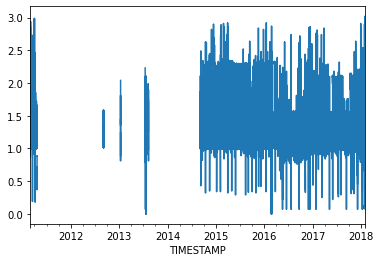

In [42]:
_ = multivar['level'].plot()

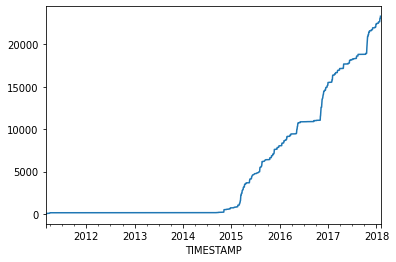

In [43]:
_ = multivar['extravasao_contagem_cum'].plot()